In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, mean_squared_error
  
plt.style.use('ggplot')

In [2]:
N_READ_FILES = 10

df = pd.DataFrame()
for filename in tqdm(os.listdir('DataLagsMayPklNew/')[:N_READ_FILES]):
    if '.pkl' in filename:
        data = pd.read_pickle(f'DataLagsMayPklNew/{filename}')
        df = pd.concat([df, data])
        
df = df.reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
cols = df.columns[~df.columns.str.contains('demand_')]
df[cols].isna().sum()

product_rk           0
store_location_rk    0
period_start_dt      0
demand               0
PROMO1_FLAG          0
PROMO2_FLAG          0
PRICE_REGULAR        0
PRICE_AFTER_DISC     0
NUM_CONSULTANT       0
AUTORIZATION_FLAG    0
PROMO12_FLAG         0
NO_FILTER            0
dtype: int64

In [8]:
## нет миссингов

In [9]:
df[cols].dtypes

product_rk             int64
store_location_rk      int64
period_start_dt       object
demand               float64
PROMO1_FLAG          float64
PROMO2_FLAG          float64
PRICE_REGULAR        float64
PRICE_AFTER_DISC     float64
NUM_CONSULTANT       float64
AUTORIZATION_FLAG    float64
PROMO12_FLAG           int64
NO_FILTER              int64
dtype: object

In [20]:
df[cols].describe().applymap('{:,.2f}'.format)

,product_rk,store_location_rk,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,PROMO12_FLAG,NO_FILTER
count,"3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00","3,418,374.00"
mean,"68,079.04",938.66,1.06,0.42,0.00,"1,666.07","1,162.96",0.10,0.81,0.84,1.00
std,"29,935.09",264.33,2.80,0.49,0.06,"2,149.61","1,474.79",0.66,0.39,0.99,0.00
min,"11,389.00",453.00,0.00,0.00,0.00,0.59,0.30,0.00,0.00,0.00,1.00
25%,"43,899.00",764.00,0.12,0.00,0.00,269.04,232.00,0.00,1.00,0.00,1.00
50%,"75,563.00","1,005.00",0.75,0.00,0.00,600.00,504.00,0.00,1.00,0.00,1.00
75%,"92,438.00","1,143.00",1.00,1.00,0.00,"2,420.00","1,615.09",0.00,1.00,2.00,1.00
max,"156,048.00","1,380.00","1,160.00",1.00,1.00,"51,999.00","38,999.25",8.00,1.00,3.00,1.00


In [ ]:
## 

In [49]:
df.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,...,demand_lag26_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag26_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w28D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w28D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling
0,44467,1143,2016-12-26,1.344828,1.0,0.0,312.000000,271.285714,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45315,1143,2016-12-26,9.000000,1.0,0.0,629.000000,629.000000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36220,1143,2016-12-26,1.000000,1.0,0.0,171.000000,171.000000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78148,1143,2016-12-26,1.000000,1.0,0.0,4041.857143,2020.928571,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45922,1143,2016-12-26,1.000000,1.0,0.0,243.000000,243.000000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df.groupby(['product_rk', 'store_location_rk'])['demand'].count().sort_values()

product_rk  store_location_rk
11389       1034                   1
89522       1173                   1
            1005                   1
89521       1143                   1
            637                    1
                                ... 
43998       1281                 154
46255       1281                 154
45312       764                  154
40370       637                  154
45315       1281                 155
Name: demand, Length: 161740, dtype: int64

<Axes: xlabel='period_start_dt'>

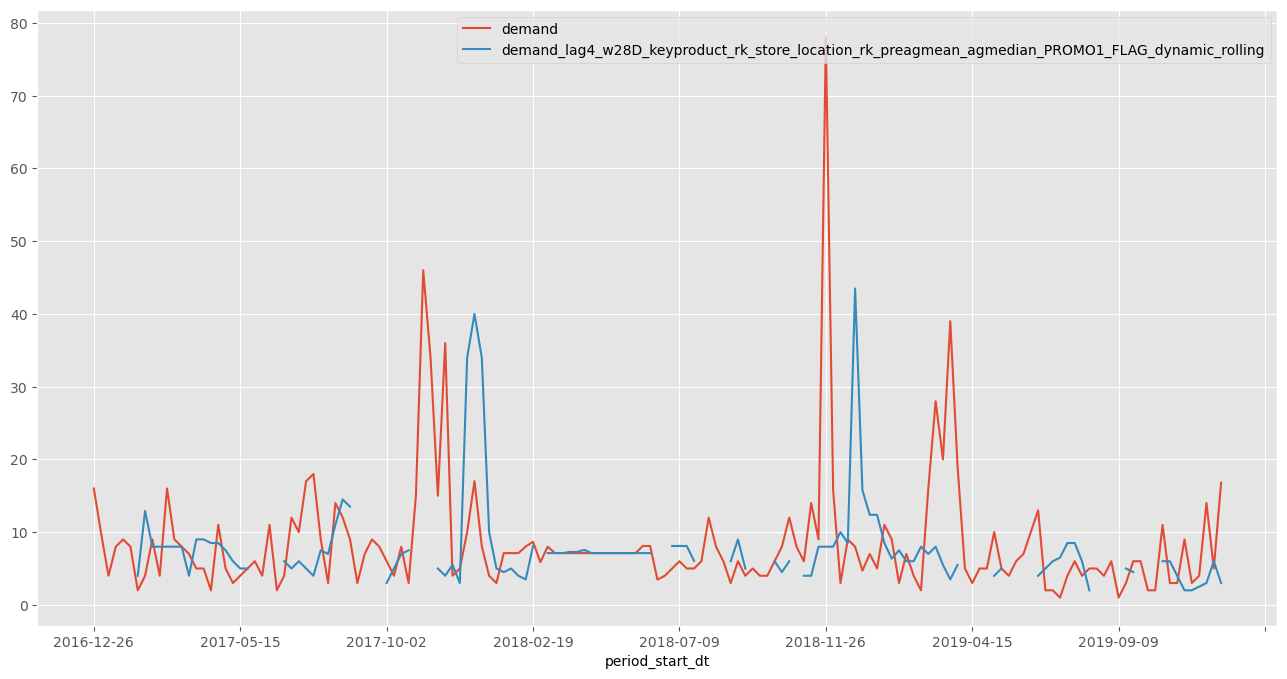

In [71]:
product, store = 45315, 1281
# feature = 'demand_lag26_w28D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling'
# feature = 'demand_lag8_w28D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO12_FLAG_dynamic_rolling'
# feature = 'demand_lag8_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO12_FLAG_dynamic_rolling'
feature = 'demand_lag4_w28D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling'


df[(df['product_rk'] == product) & (df['store_location_rk'] == store)].\
        sort_values('period_start_dt').set_index('period_start_dt')[['demand'] + [feature]].plot(figsize=(16, 8))

In [ ]:
df[]

In [60]:
df.columns[df.columns.str.contains('PROMO')]

Index(['PROMO1_FLAG', 'PROMO2_FLAG', 'PROMO12_FLAG',
       'demand_lag4_w28D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling',
       'demand_lag4_w28D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling',
       'demand_lag4_w56D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling',
       'demand_lag4_w56D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling',
       'demand_lag4_w182D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling',
       'demand_lag4_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling',
       'demand_lag4_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling',
       'demand_lag4_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling',
       'demand_lag8_w28D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling',

In [21]:
import requests 
from bs4 import BeautifulSoup as bs

In [22]:
url = 'https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_New_York_(state)'
req = requests.get(url)
soup = bs(req.text)

In [44]:
def parseUniversity(url, title):
    req = requests.get(url)
    soup = bs(req.text)
    try:
        website = soup.find('span', 'official-website').find('a')['href']
    except:
        website = None
    universities[title]['website'] = website
    try:
        address = soup.find('td', {'class': 'infobox-data adr'}).text
    except:
        address = None
    universities[title]['address'] = address

universities = {}
table = soup.find_all('div', {'class': 'div-col'})[-1]
for row in tqdm(table.find_all('li')):
    title = row.text
    universities[title] = {}
    parseUniversity('https://en.wikipedia.org' + row.find('a')['href'], title)

  0%|          | 0/15 [00:00<?, ?it/s]

In [47]:
pd.DataFrame.from_dict(universities, orient='index').reset_index().to_excel('Universities.xlsx', index=False)